# EcoFOCIpy SBE16 QC example (seperated)

see [EcoFOCIpy_21bspr2a_sbe16_6902.ipynb](EcoFOCIpy_21bspr2a_sbe16_6902.ipynb) for initial processing and formatting.  Data would have been convertted from raw instrument format to csv files, initial dirty plots created and a meta-data rich and meta-data poor dataset would have been created.  The metadata poor csv file is used for the initial preliminary data archive, the metadata rich netcdf file is used for QC procedures and eventual final data archive.

**Two Options**
- use xarray to load the netcdf data directly (working file), or pandas to load the csv file (initial archive)
- use erddapy to load the ERDDAP hosted dataset

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

- **TODO** Programmatically simplify following tools

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import pandas as pd
import xarray as xr
import datetime
import ecofocipy.io.erddap as erddap

import ecofocipy.metaconfig.load_config as load_config

In [2]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2021/Moorings/21bspr2a/'

In [3]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'rawconverted/sbe16/21bspr2a_sbe16_6902_1m.cnv'
instrument = 'SBE-16 6902'
mooring_meta_file = user_data_dir+'logs/21BSPR-2A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/sbe16_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 's16'
###############################################################

In [4]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [6]:
# this task only needed to be run once in the initial processing routine
# (sbe16_wop_nc.autotrim_time().to_dataframe()).to_csv(filename.replace('nc','csv')) #because the raw archived csv file doesn't trim out deck data, start with this file to edit 

#if it wasn't run, you can ingest the working netcdf file -> export it to csv as it should have been saved as a trimmed file, and work on that csv for manual edits
depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+str(depth).zfill(4)+'m.nc'
sbe16_wop_nc = xr.load_dataset(user_data_dir+'working/'+filename)
# sbe16_wop_nc.to_dataframe()).to_csv(filename.replace('nc','csv'))

In [7]:
url = "http://ecofoci-field.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [8]:
#grap deploy/recover cast data from erddap hosted sets - you have to know which profile you want though
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2103',qclevel='preliminary',concastno='006')
# reccast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2012',qclevel='preliminary',concastno='071')

#grab archived nrt instrument and a nearby instrument for this instance
#moored_inst = erddap.erddapMooredInstretrieve(url=url,mooringid='21bspr2a',qclevel='preliminary',instrid=filename.split('.')[0])

HTTPError: Error {
    code=404;
    message="Not Found: Currently unknown datasetID=datasets_Mooring_21bspr2a_preliminary";
}


In [8]:
moored_inst.sample()

,time (UTC),depth (m),latitude (degrees_north),longitude (degrees_east),temperature,salinity,timeseries_id
2203675,2021-11-19T18:45:00Z,6.0,56.87533,-164.07033,4.6248,31.9421,21bsm2a_s16_0006m


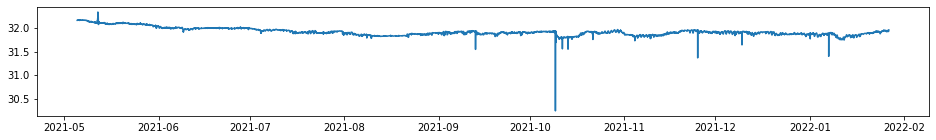

In [22]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
ax.plot(sbe16_wop_nc.time,sbe16_wop_nc.isel(depth=0,latitude=0,longitude=0).salinity)
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['S_41 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['S_41 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
#         reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
#         'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
# ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
#         reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
#         '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

### QC Notes from plots

- **no pressure var - so assume pressure correction from other depths**
- Oxygen instrument needs to be removed after 10/11 (failed cable)
- filter big Salinity Spikes

In [24]:
import ecofocipy.math.cleaning as cleaning #<- instrument specific

In [57]:
var_choice = 'salinity'
IQRcleaned = cleaning.outlier_bounds_iqr(sbe16_wop_nc[var_choice])
STDcleaned = cleaning.outlier_bounds_std(sbe16_wop_nc[var_choice],multiplier=3.25) #<-- this works well in this case

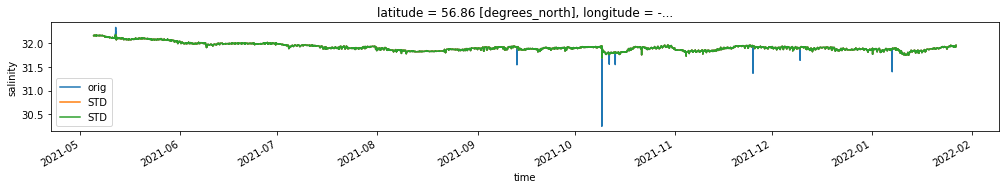

In [71]:
fig, ax = plt.subplots(figsize=(17, 2))

sbe16_wop_nc[var_choice].plot(label='orig',ax=ax)
# ((sbe16_wop_nc[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax) 
((sbe16_wop_nc[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
ax.legend()


In [78]:
#need to fill the gaps created above... only fill gaps up to 3hr
salinity_filtered = ((sbe16_wop_nc[var_choice] * 0) + STDcleaned).interpolate_na(dim='time',max_gap='3T')

### Post Manual QC load data and rebuild nc file

- using excel for a few points or a dynamic web map for multiple (a tool on ecofoci-field.pmel.noaa.gov) or any other method to identify spikes
**NOTE** if you use excel, be cautious about how your time is formatted (its important) - use custom formatting and make it of the form `yyyy-mm-ddTHH:MM:SSZ` to assure proper read in to xarray

*TODO:* use erddap hosted data 

In [74]:
# this reads the previous csv and assumes you've made modifications to the content but not the structure (record length or variable names)
sbe16_df_qc = pd.read_csv(user_data_dir+'working/'+filename.replace('nc','csv'), index_col=['time','depth','latitude','longitude']) #order is important

In [75]:
# this loads the initial working netcdf file
sbe16_wop_nc_qc = xr.load_dataset(user_data_dir+'working/'+filename)

In [76]:
sbe16_wop_nc_qc

<xarray.Dataset>
Dimensions:          (time: 25611, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time             (time) datetime64[ns] 2021-05-05T05:30:00 ... 2022-01-27
  * latitude         (latitude) float64 56.86
  * longitude        (longitude) float64 -164.1
  * depth            (depth) float64 1.0
Data variables:
    salinity         (time, depth, latitude, longitude) float64 32.16 ... 31.96
    temperature      (time, depth, latitude, longitude) float64 2.691 ... 1.157
    oxy_conc         (time, depth, latitude, longitude) float64 319.4 ... 0.0
    oxy_temperature  (time, depth, latitude, longitude) float64 2.75 ... -5.0
    oxy_percentsat   (time, depth, latitude, longitude) float64 96.19 ... 0.0
    oxy_conc_umkg    (time, depth, latitude, longitude) float64 311.5 ... 0.0
Attributes: (12/33)
    Latitude_DegMMddW:                      56 51.806 N
    Longitude_DegMMddN:                     164 03.82 W
    MooringID:                              21BSPR-2A
    platform_deployment_date:               2021-05-05T05:18:00Z
    platform_deployment_cruise_name:        DY2103
    platform_recovery_date:                 2022-01-27T00:00:00Z
    ...                                     ...
    InstrumentSerialNumber:                 6902
    InstrumentType:                         SBE-16
    date_created:                           2022-04-08T10:35:17Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

In [82]:
#replace original data with editied data
sbe16_wop_nc_qc['oxy_conc'].values=xr.Dataset.from_dataframe(sbe16_df_qc)['oxy_conc']
sbe16_wop_nc_qc['oxy_temperature'].values=xr.Dataset.from_dataframe(sbe16_df_qc)['oxy_temperature']
sbe16_wop_nc_qc['oxy_percentsat'].values=xr.Dataset.from_dataframe(sbe16_df_qc)['oxy_percentsat']
sbe16_wop_nc_qc['oxy_conc_umkg'].values=xr.Dataset.from_dataframe(sbe16_df_qc)['oxy_conc_umkg']
#replace original salinity with filtered data
sbe16_wop_nc_qc['salinity'].values=salinity_filtered


### Update global attributes

In [84]:
sbe16_wop_nc_qc.attrs.update({'QC_indicator': 'ProbablyGood'})
sbe16_wop_nc_qc.attrs.update({'history':(sbe16_wop_nc_qc.history + "\nOxgyen record trimmed due to failing instrument/cable: "+ str(datetime.datetime.today()))})
sbe16_wop_nc_qc.attrs.update({'history':(sbe16_wop_nc_qc.history + "\nSalinity had >3.25 Sigma data filtered out and linearly interpolated up to 3hrs: "+ str(datetime.datetime.today()))})


In [85]:
sbe16_wop_nc_qc.attrs.update({'date_modified':str(datetime.datetime.today())})

In [86]:
sbe16_wop_nc_qc.to_netcdf(user_data_dir+'working/'+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})